# Nearest Neighbor Methods

<img src='../pics/kNN-1.png' width=300px/>

* Nearest neighbor methods typically use the training set as the model and make predictions on new points based on how close they are to points in the training set. 
* In its simplest form, you could simply set your prediction to be the class of the closest training data point.
* But, since most datasets are noisy, the most common method nearest neighbor method is to take a weighted average of a set of k nearest neighbors (KNN).
* Given a training dataset (x1, x2, ..., xn),  with corresponding targets (y1, y2, ..., yn), we can make a prediction on a point, z, by looking at a set of nearest neighbors. The actual method of prediction depends on whether or not we are doing regression (continuous y) or classification (discrete y).
* For discrete classification targets, the prediction may be given by a maximum voting scheme weighted by the distance to the prediction point:

**_prediction(z) = max ( weighted sum of distances of points in each class )_**

* Here, our prediction is the maximum weighted value over all classes $\mathrm{(j)}$, where the weighted distance from the prediction point is usually given by the L1 or L2 distance functions.
* Continuous targets are very similar, but we usually just compute a weighted average of the target variable $\mathrm{(y)}$ by distance.
* There are many different specifications of distance metrics that we can choose, with the L1 and L2 metrics some of the most common.
* We also have to choose how to weight the distances. A straightforward way to weight the distances is by the distance itself. Points that are further away from our prediction should have less impact than nearer points. The most common way to weight is by the normalized inverse of the distance. 
* Note that k-NN is an aggregating method. For regression, we are performing a weighted average of neighbors. Because of this, predictions will be less extreme and less varied than the actual targets. The magnitude of this effect will be determined by k, the number of neighbors in the algorithm.

### Data:
We will use the 1970s Boston housing dataset which is available through the UCI ML data repository. 

----------x-values-----------
* CRIM   : per capita crime rate by town
* ZN     : prop. of res. land zones
* INDUS  : prop. of non-retail business acres
* CHAS   : Charles river dummy variable
* NOX    : nitrix oxides concentration / 10 M
* RM     : Avg. # of rooms per building
* AGE    : prop. of buildings built prior to 1940
* DIS    : Weighted distances to employment centers
* RAD    : Index of radian highway access
* TAX    : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B      : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT  : % lower status of pop

------------y-value-----------
* MEDV   : Median Value of homes in $1,000's

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
tf.reset_default_graph()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load data
* Note that we're only using certain columns for prediction - e.g. we're not using id variables or variables with very low variance

In [2]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling - scaling between 0 and 1
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

### Split into train and test sets

In [3]:
np.random.seed(13)  #make results reproducible
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.831), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [4]:
print(x_vals_train.shape, x_vals_test.shape,y_vals_train.shape,y_vals_test.shape)

(420, 10) (86, 10) (420, 1) (86, 1)


### Set up placeholders

In [5]:
# Declare k-value and batch size
k = 4
# batch size must divide evenly into the length of the test set
batch_size= 2 #len(x_vals_test)

# Create graph
sess = tf.Session()

# Placeholders
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

### Define Simple Distance Metric

In [6]:
# L1
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), axis=2)

# L2
#distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=1))

### Define Weighted Distance Metric
* Here we scale the distance functions for each feature by a factor of its standard deviation, which gives a more accurate view of which points are the "closest" neighbors or not.
* This scaling factor can also be used to down-weight or up-weight features in the nearest neighbor distance calculation, which can be useful in situations where we trust some features more or less than others.

#### Create distance metric weight matrix weighted by standard deviation

In [7]:
weight_diagonal = x_vals.std(0)
weight_matrix = tf.cast(tf.diag(weight_diagonal), dtype=tf.float32)

#### Declare weighted distance metric
$$L2 = \sqrt{(x-y)^T * A * (x-y)}$$
* Break the distance function into components for readability.
* We need to tile the weight matrix by the batch size so we use the `batch_matmul()` function to perform batch matrix multiplication across the batch size.

In [8]:
subtraction_term =  tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))
first_product = tf.matmul(subtraction_term, tf.tile(tf.expand_dims(weight_matrix,0), [batch_size,1,1]))
second_product = tf.matmul(first_product, tf.transpose(subtraction_term, perm=[0,2,1]))
distance = tf.sqrt(tf.matrix_diag_part(second_product))

### Find minimum distance for prediction
* After calculating all the training distances for each test point, we need to return the top k nearest neighbors, which we do with the `top_k()` function.
* Since the `top_k` function returns the largest values, and we want the smallest distances, we return the largest of the negative distance values.
* We then want make predictions as the weighted average of the distances of the top k neighbors.

In [18]:
#prediction = tf.arg_min(distance, 0)
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

# tf.gather is just an array-lookup function
top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), axis=[1])
#prediction = tf.reduce_mean(top_k_yvals, 1)

# Calculate MSE
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

# Calculate how many loops over training data
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

predictions = []
y_batches = []
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    temp_predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    predictions.append(temp_predictions)
    y_batches.append(y_batch)
    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

Batch #1 MSE: 5.732
Batch #2 MSE: 1.187
Batch #3 MSE: 0.742
Batch #4 MSE: 1.135
Batch #5 MSE: 1.23
Batch #6 MSE: 6.432
Batch #7 MSE: 10.732
Batch #8 MSE: 3.762
Batch #9 MSE: 1.553
Batch #10 MSE: 0.356
Batch #11 MSE: 8.375
Batch #12 MSE: 5.004
Batch #13 MSE: 9.412
Batch #14 MSE: 51.453
Batch #15 MSE: 8.653
Batch #16 MSE: 29.837
Batch #17 MSE: 5.902
Batch #18 MSE: 18.097
Batch #19 MSE: 4.053
Batch #20 MSE: 11.295
Batch #21 MSE: 147.843
Batch #22 MSE: 76.543
Batch #23 MSE: 7.055
Batch #24 MSE: 1.963
Batch #25 MSE: 9.016
Batch #26 MSE: 13.173
Batch #27 MSE: 20.936
Batch #28 MSE: 32.896
Batch #29 MSE: 9.488
Batch #30 MSE: 97.767
Batch #31 MSE: 22.78
Batch #32 MSE: 23.397
Batch #33 MSE: 13.469
Batch #34 MSE: 18.261
Batch #35 MSE: 6.264
Batch #36 MSE: 48.655
Batch #37 MSE: 3.42
Batch #38 MSE: 5.615
Batch #39 MSE: 3.842
Batch #40 MSE: 0.508
Batch #41 MSE: 1.619
Batch #42 MSE: 1.731
Batch #43 MSE: 13.07


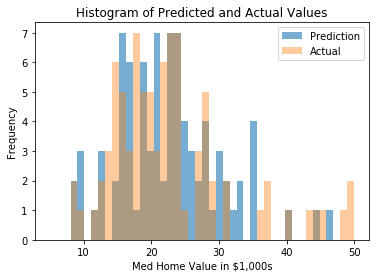

In [26]:
%matplotlib inline
predictions = np.array(predictions).reshape(-1,1)
y_batches = np.array(y_batches).reshape(-1,1)
# Plot prediction and actual distribution
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.6, label='Prediction')
plt.hist(y_batches, bins, alpha=0.4, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()